In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
MAX_EPOCHS = 25
DATA_DIR = "/Users/omgoswami/Downloads/split/Breast Cancer"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR = os.path.join(DATA_DIR, "test")
class_names = ["breast_benign", "breast_malignant"]
class_details = ["breast_benign", "breast_malignant"]

datagen = ImageDataGenerator(preprocessing_function=lambda img: img,
                             horizontal_flip=True)

train_gen = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE)

valid_gen = datagen.flow_from_directory(VAL_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE)

test_gen = datagen.flow_from_directory(TEST_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

Found 7000 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [3]:
def print_image_count(dataset, dataset_name):
    num_images = len(dataset) * BATCH_SIZE
    print(f"Number of images in {dataset_name} dataset: {num_images}")

print_image_count(train_gen, "train")
print_image_count(valid_gen, "validation")
print_image_count(test_gen, "test")

Number of images in train dataset: 7008
Number of images in validation dataset: 1504
Number of images in test dataset: 1504


In [4]:
pretrained_efficientnet_base = tf.keras.applications.efficientnet.EfficientNetB7(
    include_top=False, weights="imagenet", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), pooling="max"
)
pretrained_efficientnet_base.trainable = False

efficentNet_model = tf.keras.Sequential([
    pretrained_efficientnet_base,
    layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l=0.016),
                 activity_regularizer=tf.keras.regularizers.l1(0.006),
                 bias_regularizer=tf.keras.regularizers.l1(0.006), activation='relu'),
    layers.Dropout(rate=0.45, seed=123),
    layers.Dense(len(class_names), activation='softmax')
])

efficentNet_model.compile(tf.keras.optimizers.Adamax(learning_rate=0.001),
                          loss='categorical_crossentropy', metrics=['accuracy'])

efficentNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 batch_normalization (BatchN  (None, 2560)             10240     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 64,764,057
Trainable params: 661,250
Non-trainable params: 64,102,807
______________________________________

In [5]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=0.001,
                              mode='min')

# Train the model
history = efficentNet_model.fit(x=train_gen,
                                epochs=MAX_EPOCHS,
                                verbose=1,
                                validation_data=valid_gen,
                                validation_steps=None,
                                shuffle=False,
                                batch_size=BATCH_SIZE,
                                callbacks=[early_stopping, reduce_lr])

Epoch 1/17


2024-02-23 13:49:55.007796: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


438/438 [==============================] - 389s 864ms/step - loss: 5.4201 - accuracy: 0.9277 - val_loss: 3.1906 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 2/17
438/438 [==============================] - 421s 962ms/step - loss: 2.4274 - accuracy: 0.9450 - val_loss: 1.6866 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 3/17
438/438 [==============================] - 473s 1s/step - loss: 1.4100 - accuracy: 0.9529 - val_loss: 1.0574 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 4/17
438/438 [==============================] - 494s 1s/step - loss: 0.9767 - accuracy: 0.9520 - val_loss: 0.7746 - val_accuracy: 0.9820 - lr: 0.0010
Epoch 5/17
438/438 [==============================] - 501s 1s/step - loss: 0.7400 - accuracy: 0.9609 - val_loss: 0.6052 - val_accuracy: 0.9840 - lr: 0.0010
Epoch 6/17
438/438 [==============================] - 489s 1s/step - loss: 0.6494 - accuracy: 0.9593 - val_loss: 0.5593 - val_accuracy: 0.9713 - lr: 0.0010
Epoch 7/17
438/438 [==============================] - 494s 1s/step - 

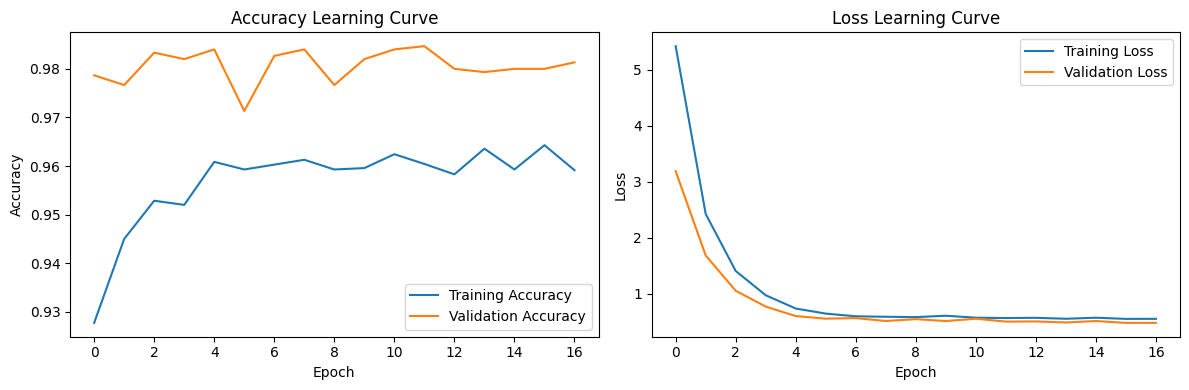

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

test_loss, test_accuracy = efficentNet_model.evaluate(test_gen)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

94/94 [==============================] - 79s 841ms/step - loss: 0.4743 - accuracy: 0.9820
Test Accuracy: 98.20%


In [8]:
predictions = efficentNet_model.predict(test_gen)
true_labels = test_gen.classes
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

94/94 [==============================] - 91s 900ms/step
Confusion Matrix:
[[728  22]
 [  3 747]]

Classification Report:
                  precision    recall  f1-score   support

   breast_benign       1.00      0.97      0.98       750
breast_malignant       0.97      1.00      0.98       750

        accuracy                           0.98      1500
       macro avg       0.98      0.98      0.98      1500
    weighted avg       0.98      0.98      0.98      1500



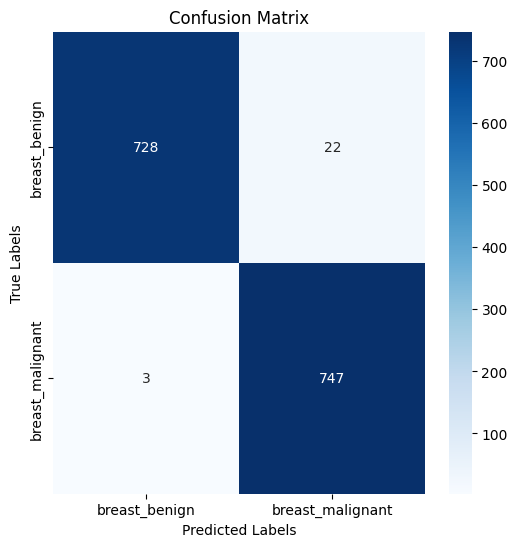

In [9]:
import seaborn as sns
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(conf_matrix, class_names)

94/94 [==============================] - 78s 833ms/step


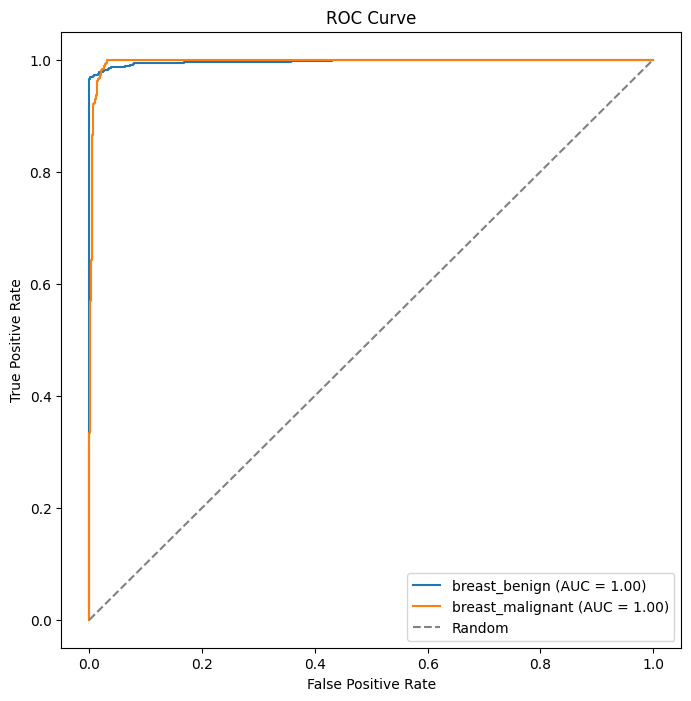

In [10]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, class_labels):
    plt.figure(figsize=(8, 8))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

y_prob = efficentNet_model.predict(test_gen)
y_true = test_gen.classes

y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))

plot_roc_curve(y_true_one_hot, y_prob, class_names)